# Imports

In [1]:
import pandas as pd
import numpy as np
import inflect
import re
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from nltk.tokenize import word_tokenize,sent_tokenize
import gensim.downloader as api
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import contractions
import unidecode
import demoji
from sklearn.preprocessing import LabelBinarizer
from emot.emo_unicode import UNICODE_EMOJI, UNICODE_EMOJI_ALIAS, EMOTICONS_EMO
from flashtext import KeywordProcessor
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Bidirectional,LSTM,Embedding, GlobalMaxPooling1D, GlobalMaxPooling3D
from tensorflow.keras.layers import Dropout
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tweepy
from pandas import Series,DataFrame
import pandas as pd
import pickle

# Data Import and Visualization

In [2]:
df = pd.read_csv('https://query.data.world/s/5xzuftmozqteqbqzopbcgxbjzusyi7')

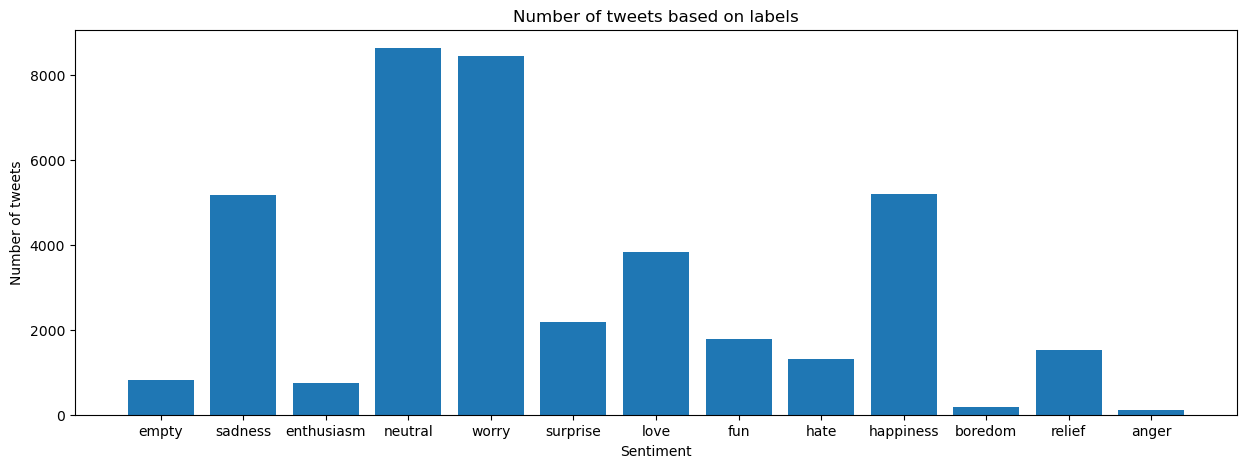

In [3]:
labels = df['sentiment']
data_vis ={}
for label in labels:
    data_vis[label] = data_vis.get(label, 0) + 1
fig = plt.figure(figsize = (15, 5))
sentiments = list(data_vis.keys())
values = list(data_vis.values())
# creating the bar plot
plt.bar(sentiments, values)
plt.xlabel("Sentiment")
plt.ylabel("Number of tweets")
plt.title("Number of tweets based on labels")
plt.show()

# Removing the unwanted labels and encoding the remaining labels

In [4]:
#converting our  above emotions to the labels and dropping the content
#df['sentiment'] = df['sentiment'].replace(labels)
#df['content']= list(map(lambda x: x.lower(), df['processed']))
#df.drop(index=df[df['sentiment'] == 'love'].index, inplace=True)
#df.drop(index=df[df['sentiment'] == 'surprise'].index, inplace=True)
#df.drop(index=df[df['sentiment'] == 'relief'].index, inplace=True)
#df.drop(index=df[df['sentiment'] == 'boredom'].index, inplace=True)
#df.drop(index=df[df['sentiment'] == 'worry'].index, inplace=True)
#df.drop(index=df[df['sentiment'] == 'anger'].index, inplace=True)
#df.drop(index=df[df['sentiment'] == 'hate'].index, inplace=True)
#df.drop(index=df[df['sentiment'] == 'empty'].index, inplace=True)
#df.drop(index=df[df['sentiment'] == 'enthusiasm'].index, inplace=True)
#df.drop(index=df[df['sentiment'] == 'fun'].index, inplace=True)
#df.drop(index=df[df['sentiment'] == 'neutral'].index, inplace=True)
removed = []
for label in df['sentiment']:
    if (label == 'love' or label == 'fun' or label == 'surprise' or label == 'enthusiasm'):
        removed.append('happiness')
    elif(label == 'worry' or label == 'hate' or label == 'anger' ):
        removed.append('sadness')
    elif(label == 'empty' or label == 'boredom' or label == 'relief'):
        removed.append('neutral')
    else:
        removed.append(label)
df.drop('sentiment', axis = 1, inplace = True)
df['sentiment'] = removed
encoder = LabelBinarizer()
encoder.fit(df.sentiment.unique())
with open("encoder", "wb") as file:
    pickle.dump(encoder, file)

# Preprocessing the data

In [5]:
#reomve pattern function, input_text is the text we want to process, the pattern is the pattern we want to remove
def remove_pattern(input_text, pattern):
    r = re.findall(pattern, input_text)
    for i in r:
        input_text = re.sub(i, '', input_text)
    return input_text

In [6]:
all_emoji_emoticons = {**EMOTICONS_EMO,**UNICODE_EMOJI_ALIAS, **UNICODE_EMOJI_ALIAS}
all_emoji_emoticons = {k:v.replace(":","").replace("_"," ").strip() for k,v in all_emoji_emoticons.items()}
kp_all_emoji_emoticons = KeywordProcessor()
for k,v in all_emoji_emoticons.items():
    kp_all_emoji_emoticons.add_keyword(k, v)

In [7]:
#preprocess the data
replacers = {'dm': 'direct message',
 'thx': 'thanks',
 'dming': 'direct messaging',
 'dmed': 'direct messaged',
 'plz': 'please',
 'u': 'you',
 'asap': 'as soon as possible',
 '...': '',
 '. . .': '',
 'r': 'are', 
 'tho': 'though', 'wassup' : 'whats up', 'lol': 'laughing out loud', 'layin': 'laying', 'y' :'why', 'bd' : 'birthday',
  'btw': 'by the way', 'ty': 'thank you', 'brb': 'be right back', 'omg': 'oh my god', 'yup' : 'yes', 'yep' : 'yes'}
def preprocess(df):
    #remove the @
    df['processed'] = np.vectorize(remove_pattern)(df['content'], "@[\w]*")
    
    #convert to lower case
    df.loc[:, 'processed'] = df.loc[:, 'processed'].str.lower()
    
    #converting don't -> do not
    removed = []
    for text in df['processed']:
        txt =[]
        for word in text.split():
            txt.append(contractions.fix(word))
        ex_txt = ' '.join(txt)
        removed.append(ex_txt)
    df.drop('processed', axis = 1, inplace = True)
    df['processed'] = removed
    
    #remove any links
    df['processed'] = df['processed'].str.replace('http[^\s]*',"")
    
    #convert emoji to text
    pr = []
    for text in df['processed']:
        pr.append(kp_all_emoji_emoticons.replace_keywords(text))
    df.drop('processed', axis = 1, inplace = True)
    df['processed'] = pr
    
    #remove the #
    df['processed'] = np.vectorize(remove_pattern)(df['processed'], "#")
    
    # converting unicode to ascii
    stemmer = PorterStemmer()
    removed = []
    for text in df['processed']:
        removed.append(unidecode.unidecode(text))
    df.drop('processed', axis = 1, inplace = True)
    df['processed'] = removed
    
    #remove the special characters, numbers, punctuations
    df['processed'] = df['processed'].str.replace("[^a-zA-Z#]", " ",regex=True)
    
    #converting common acronyms to common words
    df['processed'] = df['processed'] .str.replace('[...…]','').str.split().apply(lambda x: ' '.join([replacers.get(e, e) for e in x]))
    
     #remove the words smaller than 2
    #df['processed'] = df['processed'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
    
    #remove white spaces
    df['processed'] = df['processed'].str.strip()
    
    return df

In [8]:
df_x = df
df_y = df['sentiment']
df_x

,tweet_id,author,content,sentiment
0,1956967341,xoshayzers,@tiffanylue i know i was listenin to bad habi...,neutral
1,1956967666,wannamama,Layin n bed with a headache ughhhh...waitin o...,sadness
2,1956967696,coolfunky,Funeral ceremony...gloomy friday...,sadness
3,1956967789,czareaquino,wants to hang out with friends SOON!,happiness
4,1956968416,xkilljoyx,@dannycastillo We want to trade with someone w...,neutral
...,...,...,...,...
39995,1753918954,showMe_Heaven,@JohnLloydTaylor,neutral
39996,1753919001,drapeaux,Happy Mothers Day All my love,happiness
39997,1753919005,JenniRox,Happy Mother's Day to all the mommies out ther...,happiness
39998,1753919043,ipdaman1,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...,happiness


In [9]:
x_train, x_rem, y_train, y_rem = train_test_split(df_x, df_y, test_size=0.5)
x_test_t, x_valid_t, y_test, y_valid = train_test_split(x_rem, y_rem, test_size=0.5)
df_processed_x = preprocess(x_train)
#convert the labels into categroical data using the keras library
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)
y_valid = encoder.transform(y_valid)
#The output of the y_train and y_test will be a binary matrix and has columns equal to the number of categories in the data.
df_processed_x
y_train

C:\Users\mangu\AppData\Local\Temp\ipykernel_8392\1721477037.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed'] = df['processed'].str.replace('http[^\s]*',"")
C:\Users\mangu\AppData\Local\Temp\ipykernel_8392\1721477037.py:57: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed'] = df['processed'] .str.replace('[...…]','').str.split().apply(lambda x: ' '.join([replacers.get(e, e) for e in x]))


array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0]])

In [10]:
df_processed_x
x_train = df_processed_x['processed']
x_test = x_test_t['content']
x_valid = x_valid_t['content']

In [11]:
df_processed_x['processed'].iloc[[190]]

18617    yeah totally unfair we should just flame them ...
Name: processed, dtype: object

In [12]:
x_train.shape

(20000,)

In [13]:
x_test.shape

(10000,)

In [14]:
x_valid.shape

(10000,)

In [15]:
x_train

251      i looove guitars and playing them i think they...
13701                           hmm sorry i went mia there
5613                                 my camera is brokennn
7821     a female robin just flew into my window and i ...
2719     yes watching season all evening wish i could g...
                               ...                        
28127                                       day of writing
23684    am heading into lovely suffolk to a nice pub m...
5206     maaaaan i spent an hour on a project for work ...
27857           good morning wishing everyone a great week
26829             hugs back to you you also have that look
Name: processed, Length: 20000, dtype: object

# Tokenizing the data and padding the text

In [16]:
tokenizer = Tokenizer(5000,lower=True)
combi = pd.concat([x_train, x_test], axis = 0)
tokenizer.fit_on_texts(combi)
#Since the BiLSTM model only considers numeric values, we convert our vector of tokens to numeric sequnces, that is each
#token is represented by its frequency in the text
x_seq = tokenizer.texts_to_sequences(x_train)
X_train = pad_sequences(x_seq, maxlen = 34, padding='post')
y_seq = tokenizer.texts_to_sequences(x_test)
X_test = pad_sequences(y_seq, maxlen = 34, padding='post')
z_seq = tokenizer.texts_to_sequences(x_valid)
X_valid = pad_sequences(z_seq, maxlen = 34, padding='post')
word_index = tokenizer.word_index

# Creating Word Embeddings

In [17]:
# Glove vector contains a 50 dimensional vector corresponding to each word in dictionary.
vocab = 'glove.6B.50d.txt'
# embeddings_index is a dictionary which contains the mapping of
# word with its corresponding 50d vector.
embeddings_index = {}
with open(vocab, encoding='utf8') as f:
    for line in f:
        # splitting each line of the glove.6B.50d in a list of items- in which
        # the first element is the word to be embedded, and from second
        # to the end of line contains the 50d vector.
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [18]:
embedding_matrix = np.zeros((len(word_index)+1, 50))
for word, index in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    else:
        embedding_matrix[index] = np.zeros(50)

# Building the Baseline Model and Predicting the results

In [19]:
#EarlyStopping and ModelCheckpoint
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)
mc = ModelCheckpoint('./model.h5', monitor = 'val_accuracy', mode = 'max', verbose = 1, save_best_only = True)

In [69]:
def baseline_model(X,Y, classes):
    model=Sequential()
    model.add(Embedding(input_dim=len(word_index)+1, output_dim=50, input_length=len(X[0]), weights = [embedding_matrix], trainable=False))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(classes, activation = 'softmax'))
    model.add(GlobalMaxPooling1D())
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    ep = model.fit(X, Y, batch_size=64, epochs=10, verbose = 1, validation_data=(X_valid, y_valid))
    return model, ep

In [70]:
#Building the baseline model with only 3 labels
baselineModel, base_his = baseline_model(X_train,y_train, 3)

Epoch 1/10
313/313 [==============================] - 4s 10ms/step - loss: 1.0170 - accuracy: 0.5110 - val_loss: 0.9902 - val_accuracy: 0.5379
Epoch 2/10
313/313 [==============================] - 3s 9ms/step - loss: 0.9750 - accuracy: 0.5585 - val_loss: 0.9823 - val_accuracy: 0.5461
Epoch 3/10
313/313 [==============================] - 3s 10ms/step - loss: 0.9664 - accuracy: 0.5671 - val_loss: 0.9842 - val_accuracy: 0.5461
Epoch 4/10
313/313 [==============================] - 3s 9ms/step - loss: 0.9594 - accuracy: 0.5742 - val_loss: 0.9846 - val_accuracy: 0.5425
Epoch 5/10
313/313 [==============================] - 3s 9ms/step - loss: 0.9555 - accuracy: 0.5753 - val_loss: 0.9791 - val_accuracy: 0.5490
Epoch 6/10
313/313 [==============================] - 3s 9ms/step - loss: 0.9521 - accuracy: 0.5799 - val_loss: 0.9780 - val_accuracy: 0.5500
Epoch 7/10
313/313 [==============================] - 3s 9ms/step - loss: 0.9489 - accuracy: 0.5817 - val_loss: 0.9793 - val_accuracy: 0.5505
Epoc

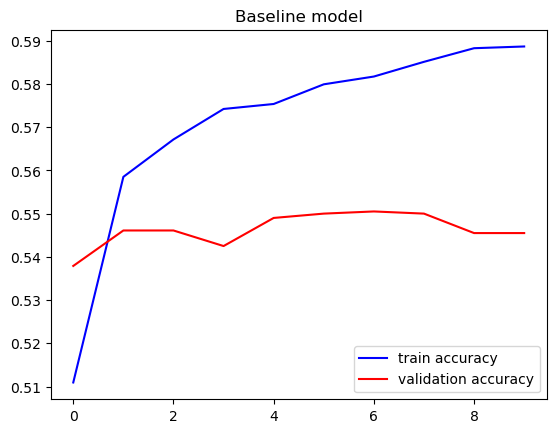

In [71]:
#Predicting with only 3 labels - Baseline Model
plt.plot(base_his.history['accuracy'],c='b',label='train accuracy')
plt.plot(base_his.history['val_accuracy'],c='r',label='validation accuracy')
plt.title("Baseline model")
plt.legend(loc='lower right')
plt.show()

In [72]:
#Results with only 3 labels - Baseline Model
y_pred = np.argmax(baselineModel.predict(X_test), axis  =  1)
y_true = np.argmax(y_test, axis = 1)
from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.64      0.56      0.60      3924
           1       0.37      0.46      0.41      2226
           2       0.62      0.61      0.61      3850

    accuracy                           0.56     10000
   macro avg       0.54      0.54      0.54     10000
weighted avg       0.57      0.56      0.56     10000



# Building the BiLSTM Model and Predicting the results

In [20]:
def build_model(X,Y, classes):
    #Dimension of our embeddings
    embedding_dim = 50
    model=Sequential()
    model.add(Embedding(input_dim=len(word_index)+1, output_dim=50, input_length=len(X[0]), weights = [embedding_matrix], trainable=False))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dense(classes, activation = 'softmax'))
    adam = keras.optimizers.Adam(learning_rate = 0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    ep = model.fit(X, Y, batch_size=128, epochs=25, verbose = 1, validation_data=(X_valid, y_valid), callbacks= [es, mc])
    return model, ep

In [21]:
#Building model with only 3 labels
bilstmModel, his=build_model(X_train,y_train, 3)

Epoch 1/25
157/157 [==============================] - ETA: 0s - loss: 1.0385 - accuracy: 0.4766
Epoch 1: val_accuracy improved from -inf to 0.50680, saving model to .\model.h5
157/157 [==============================] - 232s 1s/step - loss: 1.0385 - accuracy: 0.4766 - val_loss: 1.0114 - val_accuracy: 0.5068
Epoch 2/25
157/157 [==============================] - ETA: 0s - loss: 0.9964 - accuracy: 0.5179
Epoch 2: val_accuracy improved from 0.50680 to 0.51820, saving model to .\model.h5
157/157 [==============================] - 236s 2s/step - loss: 0.9964 - accuracy: 0.5179 - val_loss: 0.9912 - val_accuracy: 0.5182
Epoch 3/25
157/157 [==============================] - ETA: 0s - loss: 0.9865 - accuracy: 0.5196
Epoch 3: val_accuracy improved from 0.51820 to 0.52930, saving model to .\model.h5
157/157 [==============================] - 239s 2s/step - loss: 0.9865 - accuracy: 0.5196 - val_loss: 0.9808 - val_accuracy: 0.5293
Epoch 4/25
157/157 [==============================] - ETA: 0s - loss: 

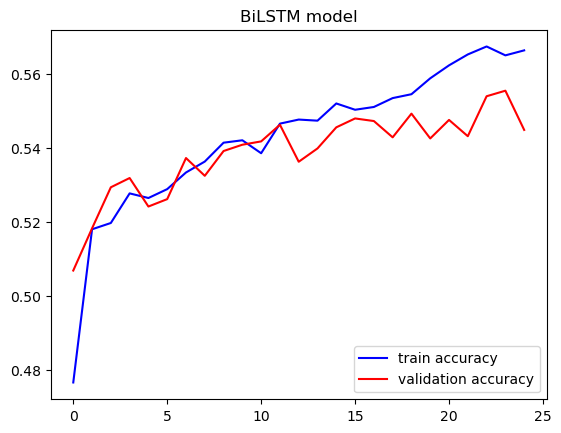

In [28]:
#Predicting with only 3 labels - bilstm model
plt.plot(his.history['accuracy'],c='b',label='train accuracy')
plt.plot(his.history['val_accuracy'],c='r',label='validation accuracy')
plt.title("BiLSTM model")
plt.legend(loc='lower right')
plt.show()

In [29]:
#Results with only 3 labels - bilstm model
y_pred =   np.argmax(bilstmModel.predict(X_test), axis  =  1)
y_true = np.argmax(y_test, axis = 1)
from sklearn import metrics
print(metrics.classification_report(y_pred, y_true))

313/313 [==============================] - 58s 186ms/step
              precision    recall  f1-score   support

           0       0.70      0.51      0.59      4677
           1       0.35      0.47      0.40      2061
           2       0.54      0.63      0.58      3262

    accuracy                           0.54     10000
   macro avg       0.53      0.54      0.52     10000
weighted avg       0.57      0.54      0.55     10000



# Extracting the tweets

In [30]:
#Put your Bearer Token in the parenthesis below
client = tweepy.Client(bearer_token='AAAAAAAAAAAAAAAAAAAAAHiaigEAAAAA1hzpI79DUjAi9q8PvGD7lfTzWjQ%3Dw9PNTdJGBWQOWxJjY9l5yP1Z7fglAF5SQGbLN6LrzUHQ5Gvbkd')

# Get tweets that contain the hashtag #petday
# -is:retweet means I don't want retweets
# lang:en is asking for the tweets to be in english
query = 'covid -is:retweet'
tweets = client.search_recent_tweets(query = query, tweet_fields=['context_annotations', 'created_at'], max_results=100)

tweet_lst = [tweet.text for tweet in tweets.data]



data = {'content': tweet_lst}
tweet_df = DataFrame(data)
tweet_pro = preprocess(tweet_df)
tweet_pro

C:\Users\mangu\AppData\Local\Temp\ipykernel_8392\1721477037.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed'] = df['processed'].str.replace('http[^\s]*',"")
C:\Users\mangu\AppData\Local\Temp\ipykernel_8392\1721477037.py:57: FutureWarning: The default value of regex will change from True to False in a future version.
  df['processed'] = df['processed'] .str.replace('[...…]','').str.split().apply(lambda x: ' '.join([replacers.get(e, e) for e in x]))


,content,processed
0,"Segundo OMS, expectativa na África subiu de 46...",segundo oms expectativa na africa subiu de par...
1,@GundiGandhi @VBB_BerlinBB COVID hat halt auch...,covid hat halt auch seinen stolz
2,@TheReelRandom It’s so bad now after covid you...,it is so bad now after covid you feel like eve...
3,@AdmiralBahroo I was going to update my PC two...,i was going to update my pc two years ago but ...
4,@JonathanSarfat1 @FiveTimesAugust @elonmusk No...,nonsense please tell the american people the b...
...,...,...
95,Dank Freedom-Ideologie sollten Kinder durch na...,dank freedom ideologie sollten kinder durch na...
96,@actuarymelissa @ChuckCallesto Apparently he d...,apparently he does woman shrugging light skin ...
97,@AGHamilton29 @irishspy Also DeSantis had appo...,also desantis had appointed democrat moskowitz...
98,@FCOUILBAULT1 Lire le document ANSM d'origine ...,lire le document ansm d origine ici


In [31]:
x_dat = tweet_pro['processed']
x_dat

0     segundo oms expectativa na africa subiu de par...
1                      covid hat halt auch seinen stolz
2     it is so bad now after covid you feel like eve...
3     i was going to update my pc two years ago but ...
4     nonsense please tell the american people the b...
                            ...                        
95    dank freedom ideologie sollten kinder durch na...
96    apparently he does woman shrugging light skin ...
97    also desantis had appointed democrat moskowitz...
98                  lire le document ansm d origine ici
99                                did they vote against
Name: processed, Length: 100, dtype: object

# Predicting the emotion from tweets

In [32]:
x_seq = tokenizer.texts_to_sequences(x_dat)
x_data = pad_sequences(x_seq, maxlen = 34, padding='post')
y_pred = bilstmModel.predict(x_data)

4/4 [==============================] - 1s 134ms/step


In [33]:
#Building model with only 3 labels
with open('encoder', 'rb') as file:
    encoder = pickle.load(file)
for index, value in enumerate(np.sum(y_pred, axis=0) / len(y_pred)):
    print(encoder.classes_[index] + ": " + str(value))

happiness: 0.2469241
sadness: 0.3413963


IndexError: index 2 is out of bounds for axis 0 with size 2